# Explore Runtimes:

In [1]:
pwd()

"/Users/zifanyu/Documents/GitHub/BulkLMM.jl/analysis/BXD"

In [2]:
cd("..")

In [3]:
include("../test/BXDdata_for_test.jl");

In [4]:
include("../src/parallel_helpers.jl");

In [5]:
include("../src/scan_distributed.jl");

In [6]:
using Plots

In [7]:
size(pheno)

(79, 35556)

In [8]:
size(pheno_y)

(79, 1)

In [9]:
size(geno)

(79, 7321)

In [10]:
size(kinship)

(79, 79)

In [11]:
(n, m, p)

(79, 35556, 7321)

## Estimate heritability independently for every trait:

### Iteratively:

In [12]:
function get_weights_for_timing(y0::Array{Float64, 2}, X0::Array{Float64, 2}, lambda0::Array{Float64, 1};
                   reml::Bool = false)
    
    # fit null lmm
    out00 = fitlmm(y0, reshape(X0[:, 1], :, 1), lambda0; reml = reml)
    # weights proportional to the variances
    sqrtw = sqrt.(makeweights(out00.h2, lambda0));
    
    return sqrtw
    
end

function get_h2s_for_timing(y0::Array{Float64, 2}, X0::Array{Float64, 2}, lambda0::Array{Float64, 1};
                   reml::Bool = false)
    
    # fit null lmm
    out00 = fitlmm(y0, reshape(X0[:, 1], :, 1), lambda0; reml = reml)
    # weights proportional to the variances
    # sqrtw = sqrt.(makeweights(out00.h2, lambda0));
    
    # return sqrtw
    return out00.h2
    
end

get_h2s_for_timing (generic function with 1 method)

In [13]:
m

35556

In [14]:
nprocs()

1

In [15]:
Threads.nthreads()

1

In [16]:
(Y0, X0, lambda0) = transform_rotation(pheno, geno, kinship); # rotate the entire matrix of all traits

In [17]:
h2s_list = Array{Float64, 1}(undef, m);
weights_list = Array{Float64, 2}(undef, n, m);

In [18]:
@time begin 
    (Y0, X0, lambda0) = transform_rotation(pheno, geno, kinship); # rotate the entire matrix of all traits
    
    for k in 1:m
        y0_k = reshape(Y0[:, k], :, 1);
        h2s_list[k] = get_h2s_for_timing(y0_k, X0, lambda0; reml = true);
    end
    
end

  8.647477 seconds (32.18 M allocations: 12.721 GiB, 27.32% gc time, 0.04% compilation time)


In [19]:
@time begin
    
    (Y0, X0, lambda0) = transform_rotation(pheno, geno, kinship); # rotate the entire matrix of all traits
    
    for k in 1:m
        y0_k = reshape(Y0[:, k], :, 1);
        weights_list[:, k] = get_weights_for_timing(y0_k, X0, lambda0; reml = true);
    end
    
end

  8.448420 seconds (32.39 M allocations: 12.821 GiB, 25.58% gc time, 0.34% compilation time)


In [20]:
get_weights_for_timing(reshape(Y0[:, 7919], :, 1), X0, lambda0; reml = true)

79-element Vector{Float64}:
 2.908346858496303
 2.689859193765633
 2.6305824455601874
 2.4302138728118043
 2.3424697213121006
 2.333212045238848
 2.2872133959327083
 2.248527248438246
 2.237276127685272
 2.2158502305549956
 2.1820799714264623
 2.164769359436277
 2.1400922422377375
 ⋮
 0.99670293760064
 0.9745192704720329
 0.9672620470243443
 0.9512951441739952
 0.882311300869066
 0.8666741771905621
 0.8551402244799341
 0.8510633380727064
 0.821512645774988
 0.7808990462637188
 0.7067335001936932
 0.16506214495842483

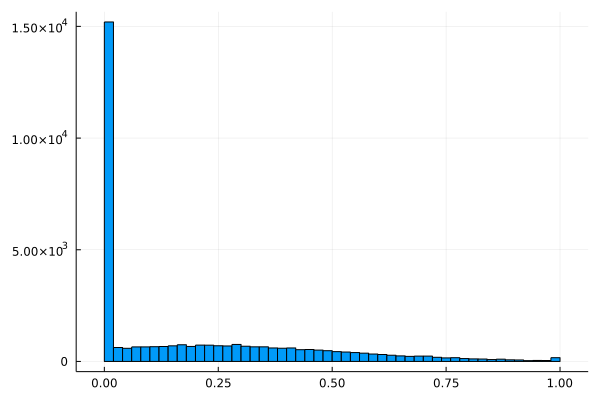

In [21]:
histogram(h2s_list, legend = false)

In [22]:
p

7321

In [33]:
lod = Array{Float64, 2}(undef, p, m);

In [ ]:
(Y0, X0, lambda0) = transform_rotation(pheno, geno, kinship); # rotate the entire matrix of all traits
    
for k = 1:m
    pheno_y0 = reshape(Y0[:, k], :, 1);
    lod[:, k] = scan_distributed(pheno_y0, X0, lambda0; nperms = 0, reml = true, original = true)
end

In [ ]:
block_bounds = quantile(h2s_list, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

In [ ]:
length(block_bounds)/2

In [ ]:
sum(map(x -> (x < block_bounds[5] && x > block_bounds[4]), h2s_list))

### Parellely:

#### Distributed-processes

In [24]:
using Distributed

In [25]:
@everywhere begin
    
    include("../test/BXDdata_for_test.jl");
    include("../src/parallel_helpers.jl");
    
    function get_h2s_for_timing(y0::Array{Float64, 2}, X0::Array{Float64, 2}, lambda0::Array{Float64, 1};
                   reml::Bool = false)
    
    # fit null lmm
    out00 = fitlmm(y0, reshape(X0[:, 1], :, 1), lambda0; reml = reml)
    # weights proportional to the variances
    # sqrtw = sqrt.(makeweights(out00.h2, lambda0));
    
    # return sqrtw
    return out00.h2
    
    end
end

In [26]:
@time begin 
    (Y0, X0, lambda0) = transform_rotation(pheno, geno, kinship); # rotate the entire matrix of all traits
    
    pmap_h2s = pmap(x -> get_h2s_for_timing(reshape(Y0[:, x], :, 1), X0, lambda0; reml = true), 1:m)
end

 10.924931 seconds (35.49 M allocations: 12.894 GiB, 20.03% gc time, 11.30% compilation time)


35556-element Vector{Float64}:
 6.113541074890939e-15
 0.020604007185902256
 4.449826736046342e-15
 1.9445947103130717e-14
 3.018457915436521e-14
 3.0747546525840177e-15
 0.17704514268544655
 0.22333064642773015
 7.151349169381022e-14
 1.0172159823088928e-14
 0.11782582924193967
 1.609962437506366e-14
 6.149509305168035e-15
 ⋮
 5.6139809289532864e-14
 2.1564696737795754e-14
 0.7420468457043501
 0.20118125986292332
 2.107468191001147e-14
 0.5571100755393413
 0.24253074543585693
 0.11454942605625149
 0.16460954712142578
 0.7255049534828831
 4.40621460088821e-14
 1.0613518583575619e-14

In [27]:
Threads.nthreads()

1